# Example of physical analysis with IPython



In [1]:
%pylab inline
import numpy
import pandas
import root_numpy

Populating the interactive namespace from numpy and matplotlib


In [2]:
folder = '/moosefs/notebook/datasets/Manchester_tutorial/'

## Reading simulation data

In [3]:
def load_data(filenames, preselection=None):
    # not setting treename, it's detected automatically
    data = root_numpy.root2array(filenames, selection=preselection)
    return pandas.DataFrame(data)

In [4]:
sim_data = load_data(folder + 'PhaseSpaceSimulation.root', preselection=None) 

Looking at data, taking first rows:

In [5]:
sim_data.head()

,H1_PX,H1_PY,H1_PZ,H2_PX,H2_PY,H2_PZ,H3_PX,H3_PY,H3_PZ,H1_Charge,H2_Charge,H3_Charge
0,3551.84,1636.96,23904.14,41507.15,15980.59,331663.64,36100.40,16546.83,295600.61,-1,1,-1
1,-2525.98,-5284.05,35822.00,-43182.91,-96553.03,585289.31,-8648.32,-16617.56,98535.13,1,-1,-1
2,-700.67,1299.73,8127.76,-1411.99,3550.96,16120.27,-13483.34,10860.77,79787.59,-1,1,1
3,3364.63,1397.30,222815.29,2192.42,1369.87,161924.75,1925.16,-551.12,40420.96,1,-1,1
4,-581.66,-1305.24,22249.59,1153.05,-1998.17,66134.22,-2820.04,-8305.43,250130.00,-1,1,-1


### Plotting some feature

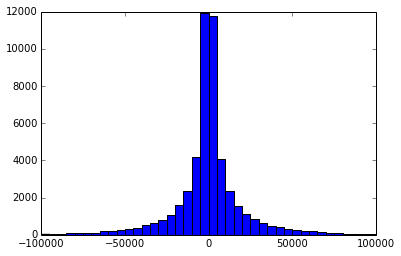

In [6]:
# hist data will contain all information from histogram
hist_data = hist(sim_data.H1_PX, bins=40, range=[-100000, 100000])

## Adding interesting features
for each particle we compute it's P, PT and energy (under assumption this is Kaon)

In [7]:
def add_momenta_and_energy(dataframe, prefix, compute_energy=False):
    """Adding P, PT and У of particle with given prefix, say, 'H1_' """
    pt_squared = dataframe[prefix + 'PX'] ** 2. + dataframe[prefix + 'PY'] ** 2.
    dataframe[prefix + 'PT'] = numpy.sqrt(pt_squared)
    p_squared = pt_squared + dataframe[prefix + 'PZ'] ** 2.
    dataframe[prefix + 'P'] = numpy.sqrt(p_squared)
    if compute_energy:
        E_squared = p_squared + dataframe[prefix + 'M'] ** 2.
        dataframe[prefix + 'E'] = numpy.sqrt(E_squared)

In [8]:
for prefix in ['H1_', 'H2_', 'H3_']:
    # setting Kaon mass to each of particles:
    sim_data[prefix + 'M'] = 493
    add_momenta_and_energy(sim_data, prefix, compute_energy=True)

## Adding features of $B$

We are able to compute 4-momentum of B, given 4-momenta of produced particles

In [9]:
def add_B_features(data):
    for axis in ['PX', 'PY', 'PZ', 'E']:
        data['B_' + axis] = data['H1_' + axis] + data['H2_' + axis] + data['H3_' + axis]
    add_momenta_and_energy(data, prefix='B_', compute_energy=False)
    data['B_M'] = data.eval('(B_E ** 2 - B_PX ** 2 - B_PY ** 2 - B_PZ ** 2) ** 0.5')

In [10]:
add_B_features(sim_data)

looking at result (with added features)

In [11]:
sim_data.head()

,H1_PX,H1_PY,H1_PZ,H2_PX,H2_PY,H2_PZ,H3_PX,H3_PY,H3_PZ,H1_Charge,...,H3_PT,H3_P,H3_E,B_PX,B_PY,B_PZ,B_E,B_PT,B_P,B_M
0,3551.84,1636.96,23904.14,41507.15,15980.59,331663.64,36100.40,16546.83,295600.61,-1,...,39711.918403,298256.193725,298256.601175,81159.39,34164.38,651168.39,657116.559870,88057.091969,657095.368711,5277.279087
1,-2525.98,-5284.05,35822.00,-43182.91,-96553.03,585289.31,-8648.32,-16617.56,98535.13,1,...,18733.305613,100300.092639,100301.304240,-54357.21,-118454.64,719646.44,731372.038019,130331.147530,731352.997274,5277.440126
2,-700.67,1299.73,8127.76,-1411.99,3550.96,16120.27,-13483.34,10860.77,79787.59,-1,...,17313.485569,81644.450519,81645.938965,-15596.00,15711.46,104035.62,106495.784261,22137.867814,106364.916303,5277.939480
3,3364.63,1397.30,222815.29,2192.42,1369.87,161924.75,1925.16,-551.12,40420.96,1,...,2002.492017,40470.532262,40473.534941,7482.21,2216.05,425161.00,425265.289437,7803.482818,425232.607246,5272.203976
4,-581.66,-1305.24,22249.59,1153.05,-1998.17,66134.22,-2820.04,-8305.43,250130.00,-1,...,8771.134082,250283.738371,250284.223918,-2248.65,-11608.84,338513.81,338761.386800,11824.618090,338720.269771,5277.881493


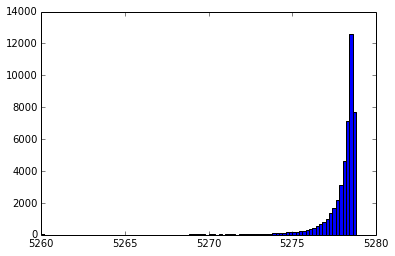

In [12]:
_ = hist(sim_data['B_M'], range=[5260, 5280], bins=100)

# Dalitz plot
computing dalitz variables and checking that no resonances in simulation

In [13]:
def add_dalitz_variables(data):
    """function to add Dalitz variables, names of prudicts are H1, H2, H3"""
    for i, j in [(1, 2), (1, 3), (2, 3)]:
        momentum = pandas.DataFrame()
        for axis in ['E', 'PX', 'PY', 'PZ']:
            momentum[axis] = data['H{}_{}'.format(i, axis)] + data['H{}_{}'.format(j, axis)]
        
        data['M_{}{}'.format(i,j)] = momentum.eval('(E ** 2 - PX ** 2 - PY ** 2 - PZ ** 2) ** 0.5')

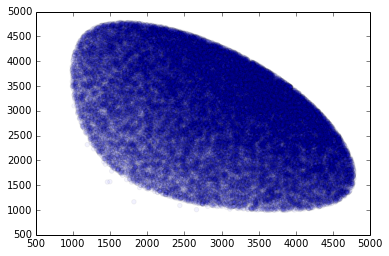

In [14]:
add_dalitz_variables(sim_data)
scatter(sim_data.M_12, sim_data.M_13, alpha=0.05)

# Working with real data
## Preselection

In [15]:
preselection = """
 H1_IPChi2 > 1 && H2_IPChi2 > 1 && H3_IPChi2 > 1
 && H1_IPChi2 + H2_IPChi2 + H3_IPChi2 > 500
 && B_VertexChi2 < 12
 && H1_ProbPi < 0.5 && H2_ProbPi < 0.5 && H3_ProbPi < 0.5
 && H1_ProbK  > 0.9 && H2_ProbK  > 0.9 && H3_ProbK  > 0.9
 && !H1_isMuon  
 && !H2_isMuon 
 && !H3_isMuon 
"""

preselection = preselection.replace('\n', '')

In [16]:
real_data = load_data([folder + 'B2HHH_MagnetDown.root', folder + 'B2HHH_MagnetUp.root'], preselection=preselection)

### adding features

In [17]:
for prefix in ['H1_', 'H2_', 'H3_']:
    # setting Kaon mass:
    real_data[prefix + 'M'] = 493
    add_momenta_and_energy(real_data, prefix, compute_energy=True)
    
add_B_features(real_data)

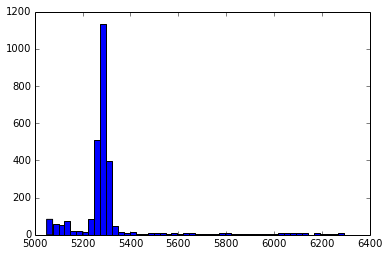

In [18]:
_ = hist(real_data.B_M, bins=50)

### additional preselection
which uses added features

In [19]:
momentum_preselection = """
 (H1_PT > 100) && (H2_PT > 100) && (H3_PT > 100)
 && (H1_PT + H2_PT + H3_PT > 4500)
 && H1_P > 1500 && H2_P > 1500 && H3_P > 1500
 && B_M > 5050 && B_M < 6300
"""

momentum_preselection = momentum_preselection.replace('\n', '').replace('&&', '&')

In [20]:
real_data = real_data.query(momentum_preselection)

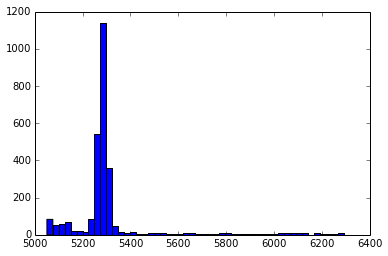

In [21]:
_ = hist(real_data.B_M, bins=50)

## Adding Dalitz plot for real data


In [22]:
add_dalitz_variables(real_data)

In [23]:
# check that 2nd and 3rd particle have same sign
numpy.mean(real_data.H2_Charge * real_data.H3_Charge)

1.0

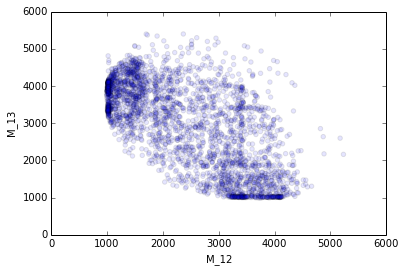

In [24]:
scatter(real_data['M_12'], real_data['M_13'], alpha=0.1)
xlabel('M_12'), ylabel('M_13')
show()

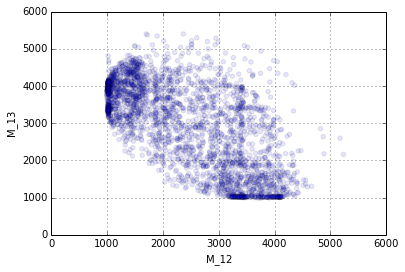

In [25]:
# lazy way for plots
real_data.plot('M_12', 'M_13', kind='scatter', alpha=0.1)

### Ordering dalitz variables
let's reorder particles so the first Dalitz variable is always greater

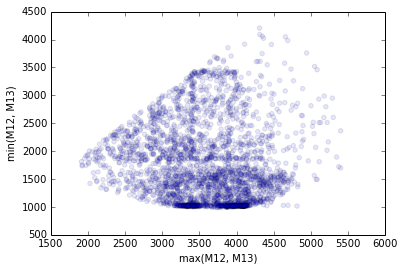

In [26]:
scatter(numpy.maximum(real_data['M_12'], real_data['M_13']),
        numpy.minimum(real_data['M_12'], real_data['M_13']),
        alpha=0.1)
xlabel('max(M12, M13)'), ylabel('min(M12, M13)')
show()

### Binned dalitz plot
let's plot the same in bins, as physicists like

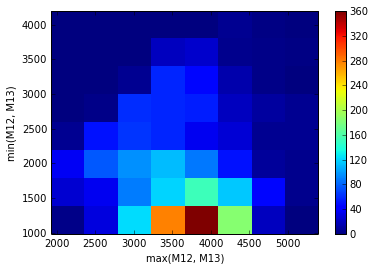

In [27]:
hist2d(numpy.maximum(real_data['M_12'], real_data['M_13']),
       numpy.minimum(real_data['M_12'], real_data['M_13']),
       bins=8)
colorbar()
xlabel('max(M12, M13)'), ylabel('min(M12, M13)')
show()

## Looking at local CP-asimmetry
adding one more column

In [28]:
real_data['B_Charge'] = real_data.H1_Charge + real_data.H2_Charge + real_data.H3_Charge

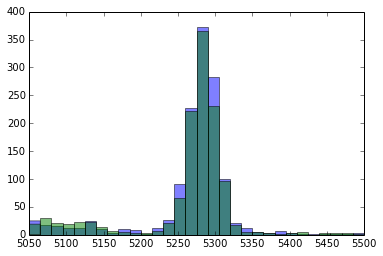

In [29]:
hist(real_data.B_M[real_data.B_Charge == +1].values, bins=30, range=[5050, 5500], alpha=0.5)
hist(real_data.B_M[real_data.B_Charge == -1].values, bins=30, range=[5050, 5500], alpha=0.5)
pass

## Leaving only signal region in mass

In [30]:
signal_charge = real_data.query('B_M > 5200 & B_M < 5320').B_Charge

counting number of positively and negatively charged B particles

In [31]:
n_plus  = numpy.sum(signal_charge == +1)
n_minus = numpy.sum(signal_charge == -1)

In [32]:
print n_plus, n_minus, n_plus - n_minus

1115 1012 103


In [33]:
print 'asymmetry = ', (n_plus - n_minus) / float(n_plus + n_minus)

asymmetry =  0.0484250117536


### Estimating significance of deviation (approximately)

we will assume that $N_{+} + N_{-}$, and under null hypothesis each observation contains with $p=0.5$ positive or negative particle.

So, under these assumptions $N_{+}$ is distributed as binomial random variable.

In [34]:
# computing properties of n_plus according to H_0 hypothesis.
n_mean = len(signal_charge) * 0.5
n_std = numpy.sqrt(len(signal_charge) * 0.25)

print 'significance = ', (n_plus - n_mean) / n_std

significance =  2.23333298248


# Subtracting background
using RooFit to fit mixture of exponential (bkg) and gaussian (signal) distributions.

Based on the fit, we estimate number of events in mass region

In [35]:
# Lots of ROOT imports for fitting and plotting
from rootpy import asrootpy, log
from rootpy.plotting import Hist, Canvas, set_style, get_style
from ROOT import (RooFit, RooRealVar, RooDataHist, RooArgList, RooArgSet,
                  RooAddPdf, TLatex, RooGaussian, RooExponential )

In [36]:
def compute_n_signal_by_fitting(data_for_fit):
    """
    Computing the amount of signal with in region [x_min, x_max]
    returns: canvas with fit, n_signal in mass region 
    """
    # fit limits
    hmin, hmax = data_for_fit.min(), data_for_fit.max()
    
    hist = Hist(100, hmin, hmax, drawstyle='EP')
    root_numpy.fill_hist(hist, data_for_fit)

    # Declare observable x
    x = RooRealVar("x","x", hmin, hmax)
    dh = RooDataHist("dh","dh", RooArgList(x), RooFit.Import(hist))

    frame = x.frame(RooFit.Title("D^{0} mass"))
    # this will show histogram data points on canvas 
    dh.plotOn(frame, RooFit.MarkerColor(2), RooFit.MarkerSize(0.9), RooFit.MarkerStyle(21))

    # Signal PDF
    mean = RooRealVar("mean", "mean", 5300, 0, 6000)
    width = RooRealVar("width", "width", 10, 0, 100)
    gauss = RooGaussian("gauss","gauss", x, mean, width)
    
    # Background PDF
    cc = RooRealVar("cc", "cc", -0.01, -100, 100)
    exp = RooExponential("exp", "exp", x, cc)
    
    # Combined model
    d0_rate = RooRealVar("D0_rate", "rate of D0", 0.9, 0, 1)
    model = RooAddPdf("model","exp+gauss",RooArgList(gauss, exp), RooArgList(d0_rate))
    
    # Fitting model
    result = asrootpy(model.fitTo(dh, RooFit.Save(True)))
    mass = result.final_params['mean'].value
    hwhm = result.final_params['width'].value
    
    # this will show fit overlay on canvas
    model.plotOn(frame, RooFit.Components("exp"), RooFit.LineStyle(3), RooFit.LineColor(3))
    model.plotOn(frame, RooFit.LineColor(4))

    # Draw all frames on a canvas
    canvas = Canvas()
    frame.GetXaxis().SetTitle("m_{K#pi#pi} [GeV]")
    frame.GetXaxis().SetTitleOffset(1.2)
    frame.Draw()
    
    # Draw the mass and error label
    label = TLatex(0.6, 0.8, "m = {0:.2f} #pm {1:.2f} GeV".format(mass, hwhm))
    label.SetNDC()
    label.Draw()

    # Calculate the rate of background below the signal curve inside (x_min, x_max)
    x_min, x_max = 5200, 5330
    
    x.setRange(hmin, hmax)
    bkg_total = exp.getNorm(RooArgSet(x))
    sig_total = gauss.getNorm(RooArgSet(x))
    
    x.setRange(x_min, x_max)
    bkg_level = exp.getNorm(RooArgSet(x))
    sig_level = gauss.getNorm(RooArgSet(x))
    
    bkg_ratio = bkg_level / bkg_total
    sig_ratio = sig_level / sig_total
    
    n_elements = hist.GetEntries()
    
    # TODO - normally get parameter form fit_result
    sig_part = (d0_rate.getVal())
    bck_part = (1 - d0_rate.getVal())
    
    # estimating ratio of signal and background
    bck_sig_ratio = (bkg_ratio * n_elements * bck_part) / (sig_ratio * n_elements * sig_part)
    
    # n_events in (x_min, x_max)
    n_events_in_mass_region = numpy.sum((data_for_fit > x_min) & (data_for_fit < x_max))
    
    n_signal_in_mass_region = n_events_in_mass_region / (1. + bck_sig_ratio)
    
    return canvas, n_signal_in_mass_region

In [37]:
B_mass_range = [5050, 5500]

mass_for_fitting_plus = real_data.query('(B_M > 5050) & (B_M < 5500) & (B_Charge == +1)').B_M
mass_for_fitting_minus = real_data.query('(B_M > 5050) & (B_M < 5500) & (B_Charge == -1)').B_M


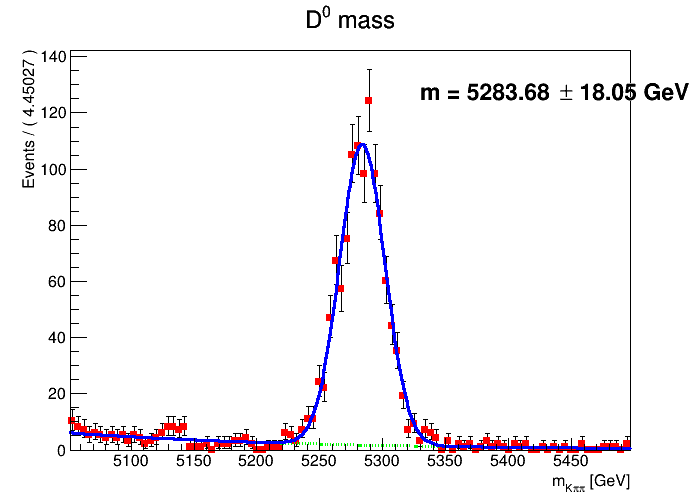

In [38]:
canvas_plus, n_positive_signal = compute_n_signal_by_fitting(mass_for_fitting_plus)
canvas_plus

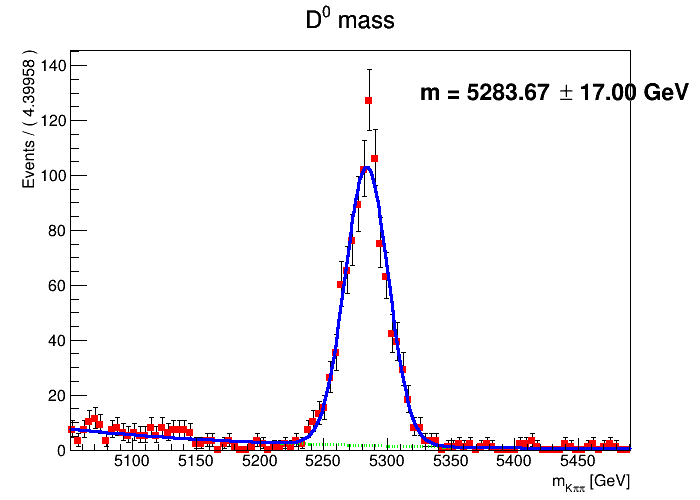

In [39]:
canvas_minus, n_negative_signal = compute_n_signal_by_fitting(mass_for_fitting_minus)
canvas_minus

## Computing asymmetry with subtracted background

In [40]:
print n_positive_signal, n_negative_signal
print (n_positive_signal - n_negative_signal) / (n_positive_signal + n_negative_signal)

1071.56766778 970.247956339
0.0496223607272


In [41]:
n_mean = 0.5 * (n_positive_signal + n_negative_signal)
n_std = numpy.sqrt(0.25 * (n_positive_signal + n_negative_signal))
print (n_positive_signal - n_mean) / n_std

2.24225851983
